<a href="https://colab.research.google.com/github/jeongsukko/jejumaster-1/blob/main/3%EC%9D%BC%EC%B0%A8_%EC%9B%B9%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D_01_%EC%BD%94%EB%9E%A9_OpenAPI%EB%A5%BC%EC%9D%B4%EC%9A%A9%ED%95%9C%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%88%98%EC%A7%91_%20%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 웹 데이터 분석

## 1. OpenAPI를 이용한 데이터 수집

**[주의!] (코랩)한글 폰트 지정하는 방법**

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 코랩에서 위 코드를 실행시킨 후  반드시 코랩 메뉴: "런타임>런타임 다시 시작" 합니다.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,456 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and dire

### 한글 폰트 지정하기

In [1]:
import matplotlib.pyplot as plt
#(Mac한글 폰트 지정하기)
plt.rcParams['font.family'] = 'NanumBarunGothic'

#(windows)한글 폰트 지정하기
# plt.rcParams['font.family'] = 'Malgun Gothic'

---

### 01.웹 크롤링의 이해
- **웹 크롤링(Web Crawling)**: 웹 페이지로부터 원하는 정보를 추출하는 기법, 보통 여러 페이지 탐색하는 방법,
- **웹 스크래핑(Web Scraping)**: 특정한 하나의 웹 페이지를 탐색하는 방법
- **웹 크롤링과 웹 스크래핑의  방법이 동일하여 보통 웹 크롤링이라고 통칭해서 부른다.**

---------------------

## 02.네이버 OpenAPI 사용하기

### # 1.네이버 OpenAPI 신청하기 : 네이버 **검색(책, 뉴스, 쇼핑)

- 네이버 OpenAPI 소개: https://developers.naver.com/products/intro/plan/
- 개발 가이드 보기: https://developers.naver.com/docs/serviceapi/search/news
- OpenAPI 신청하기: https://developers.naver.com/apps/#/register

### # 2.네이버 OpenAPI 사용 예 : 책 검색

### [실습] : 네이버 검색 API 사용하여 데이터 수집하기

#### 라이브러리 설치하기

In [2]:
# 정적 크롤링을 위한 requests 설치
!pip install requests

In [7]:
import os
import sys
import urllib.request
import datetime
import time
import json
import pandas as pd

now = datetime.datetime.now()
datas = []   #csv파일을 위한 변수

client_id = 'dDtc4_41eDJOxxpPTVF1'  # 자신의 client_id
client_pw = 'qOvBssT2zs'            # 자신의 client_secret
PATH = './sample_data'              # 수집 데이터 저장 폴더


#[CODE 1]
def get_RequestUrl(url):
    req = urllib.request.Request(url)
    req.add_header("X-Naver-Client-Id", client_id)
    req.add_header("X-Naver-Client-Secret", client_pw)

    try:
        response = urllib.request.urlopen(req)
        if response.getcode() == 200:
            print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Url Request Success")
            return response.read().decode('utf-8')

    except Exception as e:
#         if response.getcode() == 400 and datas:
#             return None
        print(e)
        print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Error for URL : {url}" )
        return None


#[CODE 2]  네이버 검색 API
def get_NaverSearch(node, srcText, start, display):
    base = "https://openapi.naver.com/v1/search"
    node = "/%s.json" % node
    parameters = "?query=%s&start=%s&display=%s" % (urllib.parse.quote(srcText), start, display)

    url = base + node + parameters
    responseDecode = get_RequestUrl(url)   #[CODE 1]

    if (responseDecode == None):
        return None
    else:
        return json.loads(responseDecode)

#[CODE 3]
def get_PostData(node, post, jsonResult, cnt):
    if node == 'book':
        data = {'제목':post['title'],
                '저자':post['author'],
                '출판사':post['publisher'],
                '출간일':post['pubdate'],
                '링크':post['link'],
                '이미지':post['image']}
    elif node == 'news':
        data = {'제목':post['title'],
                '링크':post['originallink'],
                '내용':post['description']}
    elif node == 'shop':
        data = {'제목':post['title'],
                '브랜드':post['brand'],
                '제조사':post['maker'],
                '가격':post['lprice'],
                '이미지':post['image']}

    jsonResult.append(data)
    datas.append(data)

    return

#[CODE 0]
def main():
    global node, srcText

    nodeType = '''-----------------------------
    네이버 검색 대상입니다.
      1.book,  2.news,  3.shop
    -----------------------------'''
    print(nodeType)
    node = input('번호를 선택하세요.')
    if node == '1': node = 'book'
    elif node == '2': node = 'news'
    elif node == '3': node = 'shop'

    srcText = input(f'{node} 검색할 검색어를 입력하세요: ')

    display, cnt = 100, 0
    jsonResult = []
    jsonResponse = get_NaverSearch(node, srcText, 1, display)  #[CODE 2]
    total = jsonResponse['total']

    while ((jsonResponse != None) and (jsonResponse['display'] != 0)):
        for post in jsonResponse['items']:
            cnt += 1
            get_PostData(node, post, jsonResult, cnt)  #[CODE 3]

        start = jsonResponse['start'] + jsonResponse['display']
        jsonResponse = get_NaverSearch(node, srcText, start, total)
#     print(f'가져올 데이터 : {total} 건')

    with open(f'{PATH}/naver_{node}_{srcText}', 'w', encoding='utf8') as outfile:
        jsonFile = json.dumps(jsonResult,  indent=4, sort_keys=True,  ensure_ascii=False)

        outfile.write(jsonFile)

    print("가져온 데이터 : %d 건" %(cnt))



    # csv 파일로 저장하기
    file = f'{PATH}/naver_{node}_{srcText}.csv'
    df = pd.DataFrame(datas)
    df.to_csv(file, index=False, encoding="utf-8-sig")
    print(f'{PATH}/naver_{node}_{srcText}.csv SAVED')
    return df

#-----------
# 시작
#-----------
df = main()
df

-----------------------------
    네이버 검색 대상입니다.
      1.book,  2.news,  3.shop
    -----------------------------
번호를 선택하세요.2
news 검색할 검색어를 입력하세요: 한국관광공사
[2023년11월01일 01시51분04초] Url Request Success
HTTP Error 400: Bad Request
[2023년11월01일 01시51분04초] Error for URL : https://openapi.naver.com/v1/search/news.json?query=%ED%95%9C%EA%B5%AD%EA%B4%80%EA%B4%91%EA%B3%B5%EC%82%AC&start=101&display=324521
가져온 데이터 : 100 건
./sample_data/naver_news_한국관광공사.csv SAVED


,제목,링크,내용
0,[EDITOR’S LETTER] 포퓰리즘과 헤어질 결심,https://economychosun.com/site/data/html_dir/2...,신기술을 활용해 해를 거듭할수록 발전하는 모습을 기대한다.-김지연 회사원[READE...
1,갑질·실언 논란 이재환 <b>한국관광공사</b> 부사장 사의표명..퇴직 처리,http://news.mt.co.kr/mtview.php?no=20231101102...,<b>한국관광공사</b>는 이재환 부사장 겸 <b>관광</b>산업본부장이 1일 오전...
2,"<b>관광공사</b>, 올해 특별재난지역 대상 여행상품 기획전",https://www.yna.co.kr/view/AKR2023110106580003...,문화체육<b>관광</b>부와 <b>한국관광공사</b>는 올해 지정된 특별재난지역 2...
3,<b>한국</b> 찾는 태국 <b>관광</b>객 '입국 문턱'에 감소세…日 반사이익 얻나,https://www.yna.co.kr/view/AKR2023103014700007...,올해 <b>한국관광공사</b> 지원으로 <b>한국</b>을 찾은 태국 단체 포상<b...
4,40% 할인받고 특별재난지역에서 착한 여행하세요!,http://www.joynews24.com/view/1648814,문화체육<b>관광</b>부(이하 문체부)와 <b>한국관광공사</b>(이하 <b>공사...
...,...,...,...
95,하동군 디지털 <b>관광</b>주민증 공모사업 선정,http://www.gndomin.com/news/articleView.html?i...,/하동군 하동군은 문화체육<b>관광</b>부와 <b>한국관광공사</b>가 추진하는 ...
96,"현장칼럼-국민의힘, 사천·남해·하동 내년 총선 누가 뛰나?",http://www.gndomin.com/news/articleView.html?i...,이러한 가운데 최근 <b>한국관광공사</b> 김장실 사장이 총선 출마 의지를 피력했...
97,K-링크 페스티벌 12월 개최...보아x샤이니x에스파x제로베이스원 출연,https://www.bntnews.co.kr/article/view/bnt2023...,"‘2023 K-링크 페스티벌’은 문화체육<b>관광</b>부가 주최하고, <b>한국관..."
98,[이런 여행] 기품과 역사 서린 고택... 정겨운 마을에서 하룻밤 묵어 갈까,https://www.hankookilbo.com/News/Read/A2023103...,<b>한국관광공사</b>가 11월 추천 여행지로 ‘이야기가 있는 고택’을 꼽았다. ...




---



In [10]:
import requests

requests.get("https://google.com")
#정상적으로 실행이 되면 코드 200이 응답이 온다

<Response [200]>

##네이버오픈AI를 이용한 책 검색하기

In [14]:
import requests

response = requests.get("https://google.com")

# 응답 상태
print('#응답 상태: ', response.status_code)

# 응답 바이너리 원문
print('#응답 바이너리 원문: ', response.content)

# 응답 UTF-8로 인코딩된 문자열
print('#응답 UTF-8로 인코딩된 문자열: ', response.text)

# 응답 헤더
print('#응답 헤더: ', response.headers)

# 응답 헤더: 콘텐트 유형
print('#응답 헤더유형: ', response.headers['Content-Type'])

#응답 상태:  200
#응답 바이너리 원문:  b'<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="zh-TW"><head><meta content="text/html; charset=UTF-8" http-equiv="Content-Type"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>Google</title><script nonce="HXsanT_5BlvfpGAc1cG8eA">(function(){var _g={kEI:\'jLdBZe-vFcvQ1e8Pxe2QqAE\',kEXPI:\'0,1365467,207,4804,2316,383,246,5,1129120,1197748,653,380089,16115,28684,22431,1361,12315,2819,14765,4998,13744,3331,38444,889,1983,2891,3926,7828,606,29842,28444,2404,2614,3783,9708,230,20583,4,57401,2216,4437,22607,6630,7596,1,42154,2,39761,5679,1020,31123,4568,6258,23418,1252,29374,3690,2,2,1,26632,239,7916,8861,14489,873,19634,7,1922,9779,8213,34246,20199,20136,14,82,20206,8377,8048,10912,578,4825,782,1483,765,5630,10186,1804,13806,21462,11814,1633,13495,13206,7914,7652,1979,1809,5220445,2,712,5994253,2806525,141,795,29539,1,41,59,10,41,10,23940866,579,4043528,16673,39458,1445,2983,3,1558,

In [16]:
import urllib.request
import json
# 네이버 애플리케이션 등록 정보
client_id = 'dDtc4_41eDJOxxpPTVF1'  # 자신의 client_id
client_pw = 'qOvBssT2zs'            # 자신의 client_secret

# 검색어 입력
title = input("검색 도서명: ")
# url설정
url = "https://openapi.naver.com/v1/search/book.json"
query = "?query="+urllib.parse.quote(title)
option = "&display=10&start=1" # 10개씩&가져올 페이지 지정
url_query = url + query + option

#Open API 검색 요청 개체 설정
request = urllib.request.Request(url_query)
request.add_header("X-Naver-Client-Id", client_id)
request.add_header("X-Naver-Client-Secret", client_pw)

# 검색 요청 및 처리
response = urllib.request.urlopen(request)
rescode = response.getcode()

if(rescode == 200):
    result = response.read().decode('utf-8')
else:
    print("검색에 실패하였습니다.")
    exit()
# 검색 결과 parsing 해서 보기좋게 출력하기
books = json.loads(result) #검색 결과를 json타입으로 보여주기
if books == None:
    print("json.loads 실패하였습니다.")
    exit()

# books 결과 중 도서 정보가 담긴 items 항목의 내용을 parsing한다.
for book in books['items']:
    print(f"제목: {book['title']}")
    print(f"저자: {book['author']}")
    print(f"URL: {book['link']}")
    print()

검색 도서명: 그림책
제목: 수박의 전설 외전
저자: 이지은
URL: https://search.shopping.naver.com/book/catalog/41172650624

제목: 너는 특별하단다 (작은 나무 사람 펀치넬로 이야기)
저자: 맥스 루케이도
URL: https://search.shopping.naver.com/book/catalog/32455617051

제목: 태양 왕 수바: 수박의 전설
저자: 이지은
URL: https://search.shopping.naver.com/book/catalog/39944313618

제목: 밤은 언제 잠이 들지 (엄마와 아이가 잠들기 전 함께 나누는 이 세상에 대한 질문들)
저자: 라우라 위트네르
URL: https://search.shopping.naver.com/book/catalog/43013476619

제목: 끝말잇기
저자: 김영진
URL: https://search.shopping.naver.com/book/catalog/43027973618

제목: 수박 수영장(어나더커버 특별판) (안녕달 그림책)
저자: 안녕달
URL: https://search.shopping.naver.com/book/catalog/32491438189

제목: 트롤과 염소 삼 형제
저자: 맥 바넷
URL: https://search.shopping.naver.com/book/catalog/42829798618

제목: 24일 동안 열리는 크리스마스 도서관 Advent Calendar (Advent Calendar)
저자: 레슬리 심스
URL: https://search.shopping.naver.com/book/catalog/43212036630

제목: 이상한 엄마
저자: 백희나
URL: https://search.shopping.naver.com/book/catalog/32466562701

제목: 연이와 버들 도령
저자: 백희나
URL: https://search.shopping.naver.com/book/catalo

### [실습] :  네이버 Papago API 사용하여 번역하기

In [20]:
import os
import sys
import urllib.request
import datetime
import json


# client_id = 'dDtc4_41eDJOxxpPTVF1'  # 자신의 파파고 NMT API ID
# client_pw = 'qOvBssT2zs'            # 자신의 파파고 NMT API PASSWORD

news = []   #csv파일을 위한 변수

#[CODE 1]
def papago(prompt, lang=1):

    encText = urllib.parse.quote(prompt)
    if lang == 1 :
        data = "source=ko&target=en&text=" + encText
    else:
        data = "source=en&target=ko&text=" + encText
    url = "https://openapi.naver.com/v1/papago/n2mt"

    req = urllib.request.Request(url)
    req.add_header("X-Naver-Client-Id", client_id)
    req.add_header("X-Naver-Client-Secret", client_pw)

    try:
        response = urllib.request.urlopen(req, data=data.encode("utf-8") )
        if response.getcode() == 200:
            print(f"[{now.strftime('%Y년%m월%d일 %H시%M분%S초')}] Url Request Success")
            responseDecode = response.read().decode('utf-8')

            if responseDecode == None:
                return None
            else:
                return json.loads(responseDecode)

    except Exception as e:
        print(e)
        print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
        return None

# 메인
lang= int(input('[선택] 1:한글->영어, 2:영어->한글: '))
txt =  '한글' if lang==1 else '영어'

# if lang == 1:
#     txt = '한글'
# else:
#     txt = '영어'

prompt= input(f'[번역] 변환할 문장을 입력하세요.[{txt}로 입력]: ')

jsonResponse = papago(prompt, lang)  # 파파고 번역
jsonResponse
print('-'*50)
print(f"[번역 결과] => {jsonResponse['message']['result']['translatedText']}")


[선택] 1:한글->영어, 2:영어->한글: 1
[번역] 변환할 문장을 입력하세요.[한글로 입력]: 오늘 날씨 어때?
[2023년11월01일 01시51분04초] Url Request Success
--------------------------------------------------
[번역 결과] => How is the weather today?


-------------------------

### 한글 텍스트 Cleansing

#### 라이브러리 설치

In [21]:
# 자연어처리 형태소 분석 및 토큰화
!pip install nltk

In [22]:
# (한글)자연어처리 형태소 분석 및 토큰화
# (WinOS에서는 konlpy를 사용하기 위해 JDK를 설치해야 오류가 없어 코랩에서 실행함)
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 34.9 MB/s eta 0:00:00


In [23]:
# html tag parsing을 위한 라이브러리
!pip install beautifulsoup4

#### 한글 테스트 자연어 처리(Text Cleansing)

In [30]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import konlpy
import nltk

def clean_korean_documents(documents):
    #텍스트 정제 (HTML 태그 제거)
    for i, document in enumerate(documents):
        document = BeautifulSoup(document, 'html.parser').text
        documents[i] = document

    #텍스트 정제 (특수기호 제거)
    for i, document in enumerate(documents):
        document = re.sub(r'[^ ㄱ-ㅣ가-힣]', '', document) #특수기호 제거, 정규 표현식
        documents[i] = document

    #텍스트 정제 (형태소 분석)
    for i, document in enumerate(documents):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): #어간 추출
            if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
                clean_words.append(word[0])
        document = ' '.join(clean_words)
        documents[i] = document

    #텍스트 정제 (불용어 제거)
    df = pd.read_csv('https://raw.githubusercontent.com/cranberryai/todak_todak_python/master/machine_learning_text/clean_korean_documents/korean_stopwords.txt', header=None)
    df[0] = df[0].apply(lambda x: x.strip())
    stopwords = df[0].to_numpy()
    nltk.download('punkt')
    for i, document in enumerate(documents):
        clean_words = []
        for word in nltk.tokenize.word_tokenize(document):
            if word not in stopwords: #불용어 제거
                clean_words.append(word)
        documents[i] = ' '.join(clean_words)

    return documents


def clean_target_feature(data):
    x_data = data.to_list()
    return clean_korean_documents(x_data)



# ---------------------
# 1.클린징할 파일 가져오기
file = f'{PATH}/naver_{node}_{srcText}.csv'
df = pd.read_csv(file)

# 2.클린징할 컬럼 선택해서 클린징하기
# (앞 OpenAPI검색에서 2.news 검색을 한 후 실행하기)
df['제목'] = clean_target_feature(df['제목'])  # 기사 제목
df['내용'] = clean_target_feature(df['내용'])  # 기사 내용

# 3.클린징 결과 csv 파일로 저장하기
file = f'{PATH}/naver_{node}_{srcText}_clean.csv'
df.to_csv(file, index=False, encoding="utf-8-sig")
print(f'{file} SAVED')

df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


./sample_data/naver_news_한국관광공사_clean.csv SAVED


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,제목,링크,내용
0,포퓰리즘 헤어지다 결심,https://economychosun.com/site/data/html_dir/2...,기술 활용 하다 해 거듭 하다 발전 하다 모습 기대하다 김지연 회사원 마이스 육성 ...
1,가다 실언 논란 이재환 한국 관광 공사 부사 사의 표명 퇴직 처리,http://news.mt.co.kr/mtview.php?no=20231101102...,한국 관광 공사 이재환 부사 겸 관광 산업 본부 오전 사의 표명 뒤 바로 퇴직 처리...
2,관광 공사 올해 특별 재난 지역 대상 여행 상품 기획전,https://www.yna.co.kr/view/AKR2023110106580003...,문화 체육관 광부 한국 관광 공사 올해 지정 되다 특별 재난 지역 곳 대상 내달 착...
3,한국 찾다 태국 관광객 입국 문턱 감소 세 반사 이익 얻다,https://www.yna.co.kr/view/AKR2023103014700007...,올해 한국 관광 공사 지원 한국 찾다 태국 단체 포상 관광객 들다 상반기 급감 하다...
4,할인 받다 특별 재난 지역 착하다 여행 하다,http://www.joynews24.com/view/1648814,문화 체육관 광부 이하 문체부 한국 관광 공사 이하 공사 여행 있다 주말 캠페인 계...
...,...,...,...
95,하동군 디지털 관광 민증 공모 사업 선정,http://www.gndomin.com/news/articleView.html?i...,하동군 하동군 문화 체육관 광부 한국 관광 공사 추진 하다 디지털 관광 민증 사업 ...
96,현장 칼럼 국민 힘 남해 하동 내년 총선 누가 뛰다,http://www.gndomin.com/news/articleView.html?i...,이러하다 가운데 최근 한국 관광 공사 김장실 사장 총선 출마 의지 피 하다 호사 들...
97,링크 페스티벌 개최 보아 샤이니 스파 제로 베이스 출연,https://www.bntnews.co.kr/article/view/bnt2023...,링크 페스티벌 문화 체육관 광부 주최 한국 관광 공사 주관 하다 공연 미디어 넷 유...
98,이렇다 여행 기품 역사 서린 고택 정겨운 마을 하룻밤 묵다 갈다,https://www.hankookilbo.com/News/Read/A2023103...,한국 관광 공사 추천 여행지 이야기 있다 고택 꼽았다 선비 기품 서린 하룻밤 머물다...


### 텍스트 빈도수로 워드 클라우드 만들기

- **사이킷런 CountVectorizer클래스 사용 : 단어 빈도수 추출**
- **단, 한글에서 불용어 처리 및 가중치 처리 등 자연어 텍스트 전처리에 필요한 여러 가지 방법은 여기서 다루지 않는다.**

#### 라이브러리 설치

In [26]:
!pip install scikit-learn

#### 기사 제목을 토큰화 하고 빈도수 출력하기

[('관광', 54), ('공사', 30), ('부사', 15), ('개최', 15), ('여행', 12), ('부산', 10), ('발언', 10), ('중국', 9), ('이재환', 8), ('한국', 8)]


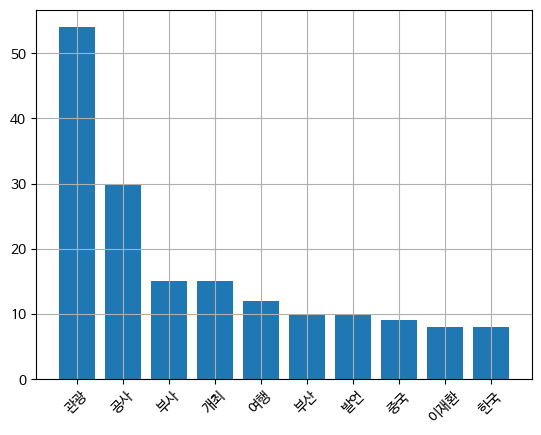

<Figure size 640x480 with 0 Axes>

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def get_wordTokenCount(corpus):
    from sklearn.feature_extraction.text import CountVectorizer

    # 기사제목을 토큰화
    vect = CountVectorizer().fit(corpus)
    count = vect.transform(corpus).toarray().sum(axis=0)

    # 토큰 빈도수로 정렬하고 토큰명 추출
    idx = np.argsort(-count)  # 내림 정렬하여 인덱스 반환: 토큰의 인덱스
    count = count[idx]        # 토큰의 빈도수
    feature_name = np.array(vect.get_feature_names_out())[idx]  # 토큰값

    # 빈도수 많은 순서대로 토큰명 10개만 출력
    print(list(zip(feature_name, count))[:10])

    return feature_name, count


def draw_wordTokenCountGraph(data, freq):
    plt.bar(data, freq)
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()

    # 그래프 그림 저장히기
    plt.savefig(f'{PATH}/{srcText}_bar_graph.png')


# 기사제목을 토큰화하여 빈도수 가져오기
feature_name, count = get_wordTokenCount(df['제목'].to_list())

# 단어(토큰) 빈도 수_Bar그래프 그리기 : 상위 10개
draw_wordTokenCountGraph(feature_name[:10], count[:10])

#### 워드 클라우드로 만들기

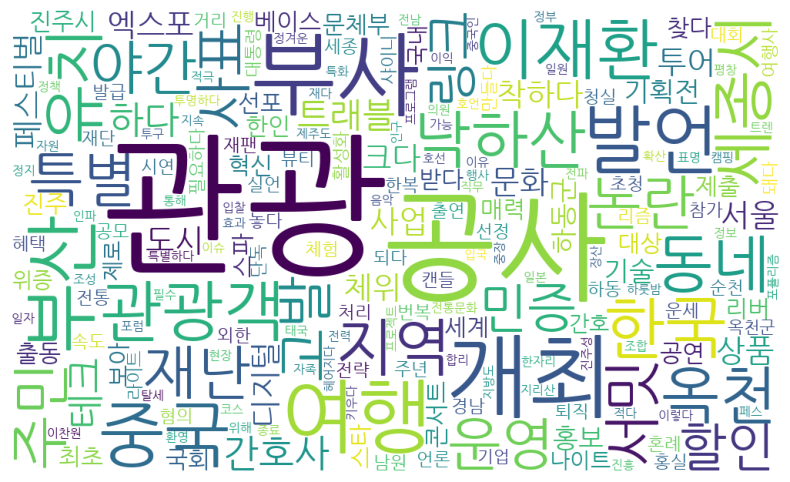

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)

# 한글 폰트 경로를 설정
font_path = 'NanumGothic'  #/usr/share/fonts/truetype/nanum/NanumGothic.ttf  (#코랩)
# font_path = 'malgun'  # C:/Windows/Fonts/   #(window에서)
# font_path = 'HMKMMAG' # C:/Windows/Fonts/HMKMMAG.TTF

# (토큰명, 빈도수) 딕셔너리 타입으로 변환
data = dict(zip(feature_name, count))

# 워드클라우드로 그래프로 시각화
wc = WordCloud(width = 1000, height = 600, background_color="white", font_path=font_path)
plt.imshow(wc.generate_from_frequencies(data)) #딕셔너리
plt.axis("off")
plt.show()

# 파일로 저장하기
wc.to_file(f'{PATH}/{srcText}_워드클라우드.png')



---



## 03.웹 이미지 수집하기

### # 1. 웹 이미지 화면에 출력하기

In [29]:
from IPython.display import Image
Image(url='https://shopping-phinf.pstatic.net/main_3815224/38152244716.20230516165404.jpg')

### # 2.  웹 이미지 파일로 저장하기

In [34]:
import requests
from io import BytesIO
from PIL import Image

# 다운받을 이미지 url
urls = [
    "https://shopping-phinf.pstatic.net/main_3815224/38152244716.20230516165404.jpg",
    "https://shopping-phinf.pstatic.net/main_3726611/37266116619.20230119071117.jpg"
]
# 파일로 저장하기
for idx, url in enumerate(urls):
    res = requests.get(url)                   # url 요청
    img = Image.open(BytesIO(res.content))    # 응답결과(res.content)바이트파일 이미지 파일로 오픈
    img.save(f'./testimg_{idx}.png', 'png')   # 'png'이미지로(만) 저장

### [실습] : 웹 이미지 수집하기
- 앞에서 저장한 쇼핑 목록에 있는 URL을 이용하여 이미지 저장하기

In [33]:
# 이미지 다운로드 하기
import pandas as pd
import requests
from io import BytesIO
from PIL import Image
import time
import os

FILE = f'{PATH}/naver_shop_여성니트.csv'  # 앞에서 자신이 검색한 쇼핑 파일
ImgFolder = f'{PATH}/download/'         # 다운받을 이미지 폴더
MAX = 10                                # 이미지 파일 다운로드 건수

def getImageUrl(file):
    print(f'읽은 파일명: {file}')
    df = pd.read_csv(file, encoding='utf-8') # 이미지가 있는 쇼핑 파일 불러오기
    return df['이미지'].to_list()

def createDirectory(directory): # 다운받을 이미지 폴더 만들기
    try:
        if not os.path.exists(directory):
            print(f'{directory} 폴더가 생성되었습니다.')
            os.makedirs(directory)
        print(f'이미지 폴더 위치 : {directory}')
    except OSError:
        print("Error: Failed to create the directory.")

def downloadImageFile(urls, imgfolder):
    start = time.time()             # 이미지 다운로드 속도 time check
    for idx, url in enumerate(urls):
        if idx == MAX:
            break  # MAX 건수만 처리하기
        res = requests.get(url)     # request.get 요청
#         print(f'[{idx+1:2>}][{time.time() - start}] : {url}')  # 이미지 다운로드 시간 체크
        print(f'[{idx+1:0>2}] : {url}')  # 이미지 다운로드 시간 체크
        img = Image.open(BytesIO(res.content))  #Img open
        img.save(f'{imgfolder}testimage_{idx}.png', 'png')
    return idx


urls = getImageUrl(FILE)                # 이미지 URL 목록 가져오기
createDirectory(ImgFolder)              # 다운받을 이미지 폴더 만들기
totalcnt = downloadImageFile(urls, ImgFolder)      # 이미지 다운로드하기
print(f'총 다운로드 건수: {totalcnt}')


읽은 파일명: ./sample_data/naver_shop_여성니트.csv


FileNotFoundError: ignored

---------------------------

끝!